# Detroit bligh ticket compliance prediction

In this notebook I have applied a binary classifier model that predicts if a blight ticket violator is likely to be compliant with the fine payment or not.

I faced this problem the first time while completing the 4th programming assignment of Coursera online course "Applied Machine Learning in Python", but I have enriched the study with more exploration of Machine Learning modelling techniques, especially for what regards the preliminary features selection task, and the model selection phase. In few words, I went beyond the scope of the original assignment, which was to obtain a binary classifier with a given performance metric, evaluated on a held-out test set.

More in detail, this notebook contains the application of a powerful strategy of hyperparameters search (see the model selection phase), that uses an evolutionary strategy for tuning the hyperparameters, rather than "sklearn" grid search methods. Indeed, applying a genetic algorithm for a "clever" exploration of the hyperparameters space led to outperforming results, both in terms of improved model performance and reduced computational time.

## Problem description
Blight violation tickets are fines issued by several  public agencies to citizens or societies who allow their real estate to remain in a deteriorated condition. Every year, the city of Detroit issues a lot of fines but many of these remain unpaid.
Since the city wants aims to increase blight ticket compliance, a useful application would be a model that can predict how likely a violator will be compliant with blight ticket payment.

### Definition of uncompliant violator
We have to define when and why a resident might fail to comply with a blight ticket. A citizen has been defined uncompliant if the fine:
- has not been payed entirely within 30 days after the hearing date
- has not been payed at all

Note that by contrast, compliant violators are the ones who pay the total fine amount within the hearing date.

### Blight ticket total amount
The blight ticket total amount is composed by different fines and additional fees: the proper fine amount (violation fine amount, excluding fees), the admin_fee (20 USD fee assigned to responsible judgments), the state fee (10 USD fee assigned to responsible judgments), an additional late fee (10% fee assigned to responsible judgments if they exceed the payment date), a    discount_amount (a disount applied during judgment), the clean up cost (cost for clean-up or graffiti removal). All these items are summed in the so-called judgment amount.

### Required model performance
The model predictions will be given as the probability (0-1) that the corresponding blight ticket will be paid on time.
The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

The goal is to build a binary classifier which AUROC score > 0.75.

## Data source
Data used for this study come from Coursera "Applied Machine Learning in Python" - Assignement 4 - online repository. According to Coursera indications, they retrieved the dataset from the [Detroit Open Data Portal](https://data.detroitmi.gov/). 
Two datasets have been provided:
- "train.csv" for model selection purpose
- "test.csv" for testing the model predictions

They have different number of columns, since the "test.csv" does not contain labelled data that are necessary to model scoring. In the original assigment by Coursera, the student has to submit the predictions obtained given the features stored in "test.csv", so test set "true" values were not directly accessible.

For the purpose of this study, I'm going to use only the "train.csv" file, splitting the whole dataset in a training and a validation set, due to the need of labelled data to evaluate the model classification performance.

### Dataset columns description
Each row in the "train.csv" file corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is "compliance", which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible during judgment. 

Notes: 
* All tickets where the violators were found not responsible are not considered for this study.
* "train.csv" contains all blight tickets issued from 2004 until 2011.

The "train.csv" file contains following columns:
train.csv & test.csv
- ticket_id - unique identifier for tickets
- agency_name - Agency that issued the ticket
- inspector_name - Name of inspector that issued the ticket
- violator_name - Name of the person/organization that the ticket was issued to
- violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
- mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
- ticket_issued_date - Date and time the ticket was issued
- hearing_date - Date and time the violator's hearing was scheduled
- violation_code, violation_description - Type of violation
- disposition - Judgment and judgement type
- fine_amount - Violation fine amount, excluding fees
- admin_fee 
- state_fee
- late_fee 
- discount_amount 
- clean_up_cost 
- judgment_amount 
- grafitti_status - Flag for graffiti violations

### Addresses files 
Coursera provides also 2 additional files, containing the "right-spelled" violation address and the latitude and longitude of each address. These csv files are:
- "addresses.csv" maps the blight ticket to the corresponding address
- "latlons.csv" maps the address to the corresponding lat and long coordinates

These file are practically used to map where the violation occurred. Note that with these additional files it is possible to use 2 numeric coordiantes, instead of the violation address, which is a much more complex data structure (you need to know the state, city, street name and number).

Note: in some cases mapping the blight violation address to the (lat, long) coordinates fails, due to errors in the transcriptions of the address. For this reason, "unmapped" tickets be filtered out from the dataset.

## Libraries
For this study, I made a broad use of "sklearn" classes and methods. But, since no evolutionary strategies are provided in "sklearn" for hyperparameters optimization, I also included "sklearn_genetic", which can be considered a powerful "add on", implementing genetic algorithm for our purpose.

In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector 

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.metrics import roc_curve, plot_confusion_matrix, roc_auc_score, plot_confusion_matrix, precision_recall_curve

In [2]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn_genetic.callbacks import ProgressBar, ThresholdStopping, ConsecutiveStopping

## Dataset cleaning and pre-processing
I wrapped the cleaning and pre-processing tasks in the following function, which accepts as input arguments the raw dataset, a list of selected columns and a flag, that was used originally to differentiate between the "train.csv" and "test.csv" dataframes.

The function does the following:
- maps the ticket id to the latitude & longitude pair (that is, the geographical localization of the violation)
- drops all tickets referring to people recognized as "innocent" by judgment
- converts the ticket issued and hearing columns to datetimes types and calculates the time delta in days
- agency name, inspector name and violator name are mapped to capital strings, to obtain a uniform spelling
- drops all tickets where missing data are found (invalid geolocalization mapping, no hearing date/ticket date recorded by mistake)

In [3]:
def prepare_dataset(raw_data, selected_columns, is_test = False):
    # get the addresses map with lat long coordinates
    addresses = pd.read_csv("data/addresses.csv")
    latlons = pd.read_csv("data/latlons.csv")
    addresses_map = addresses.merge(latlons, left_on = "address", 
                                    right_on="address").set_index("ticket_id").sort_index()
    
    if not is_test:
        # delete rows with 'compliance' = nan
        raw_data.dropna(subset = ["compliance"], inplace = True)

    raw_data = raw_data.join(addresses_map, how = "left", sort = True)
    
    raw_data.loc[:,"ticket_issued_date"] = pd.to_datetime(raw_data["ticket_issued_date"],
                                                    format = "%Y-%m-%d %H:%M:%S")
    raw_data.loc[:,"hearing_date"] = pd.to_datetime(raw_data["hearing_date"], 
                                              format = "%Y-%m-%d %H:%M:%S")
    
    raw_data.loc[:,"agency_name"] = raw_data["agency_name"].str.upper()
    raw_data.loc[:,"inspector_name"] = raw_data["inspector_name"].str.upper()
    raw_data.loc[:,"violator_name"] = raw_data["violator_name"].str.upper()


    raw_data.insert(loc = raw_data.columns.tolist().index("hearing_date") + 1, 
                     column = "days_to_hearing", 
                     value = (raw_data["hearing_date"] - raw_data["ticket_issued_date"]).dt.days.values)

    df = raw_data[selected_columns]
    
    if not is_test:
        # delete misassigned addresses and dates 
        df = df.dropna()
    return df

## Importing the dataset and choosing the appropriate columns
The raining data should be imported taking into account the special encoding, as displayed below. I also added "low_memory = False", to silence some warnings raised by pandas.

Selecting the columns subset is no trivial operation. From the original columns list, I decided to discard the following columns:
- all columns containing the violation address info, since violations are located by (lat, long)
- mailing address of the violator and non US flag. I kept only the zip code and the country description, which should be enough to locate a mailing address approximately. Note that both zip code and country id are simple strings.
- date of issue and hearing date. They are useless for future predictions, but I introduced the time delta between the 2 datetimes.
- violation description. This info is already contained in the violation code, which is a standardized id.
- all other fees except fine amount. Some of them are assigned automatically if the violator is guilty (so they are constants) and the late fee is applied only if the violator is not compliant, so using this info would cause data leakage.

In [4]:
training_data = pd.read_csv("data/train.csv", encoding = 'ISO-8859-1', index_col = 0, low_memory = False)

selected_columns = ["agency_name", "inspector_name", "violator_name", "lat" , "lon",
                    "state", "zip_code", "country",
                    "days_to_hearing", "violation_code", "disposition", "fine_amount", 
                    "compliance"]

training_set = prepare_dataset(training_data, selected_columns)

candidate_columns = [x for x in selected_columns if x != "compliance"]          
X = training_set[candidate_columns]
y = training_set["compliance"]

## Features data types
The dataset contains both categorical and numeric variables. Some of them, like the zip code, could be considered either numeric or categorical (i.e. string data type).

To ensure that all categorical columns contain only strings, it is a good practice to list all categorical columns and force string converiosn of all values. Otherwise this may cause issues while fitting the encoder preprocessor, that encodes categorical into numeric entries.

In [5]:
object_type_cols = list(X.select_dtypes(include="object"))
#X[object_type_cols] = 
X[object_type_cols].astype(str)

,agency_name,inspector_name,violator_name,state,zip_code,country,violation_code,disposition
ticket_id,,,,,,,,
18645,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","GAILES, ORBIE J","BYRD, DEAN",MI,48202,USA,9-1-36(a),Responsible by Default
18646,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","GAILES, ORBIE J","ROBERTS, CYNTHIA",MI,48235,USA,9-1-36(a),Responsible by Default
18649,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","GAILES, ORBIE J","SELDON, GLORIA",MI,48238,USA,9-1-36(a),Responsible by Default
18650,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","GAILES, ORBIE J","THOMAS, BESSIE",MI,48219,USA,9-1-36(a),Responsible by Default
18651,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","GAILES, ORBIE J","ALGORO, SHAMS",MI,48221,USA,9-1-36(a),Responsible by Default
...,...,...,...,...,...,...,...,...
292397,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","SPANN, DAMON","WILLIAMS, BRANDON",MI,48238,USA,9-1-36(a),Responsible by Default
292401,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","SPANN, DAMON","WILLIAMS, BRANDON",MI,48238,USA,9-1-83 - (Dwelling),Responsible by Default
292402,"BUILDINGS, SAFETY ENGINEERING & ENV DEPARTMENT","SPANN, DAMON","JEWELL, DOUGLAS",MI,48235,USA,9-1-81(a),Responsible by Default


## Imbalanced dataset
Performing a value count on the target variables allows to understand if the dataset is heavily imbalanced, like in this study.
As can be seen below, something like 93% of the tickets remain unpaid. So the dataset is heavily imbalanced towards the negative (0 - labelled) class and this fact is very likely to impact on the training process. Indeed, the number of positive instances (1) are very few.

In [6]:
value_counts = training_data.value_counts("compliance", normalize = "all")
value_counts

compliance
0.0    0.927464
1.0    0.072536
dtype: float64

There are many strategies that can be applied to overcome dataset imbalance. The most sophisticated can de found in "imlearn" library package. Basically, one can apply under-sampling on the majority class, over-sampling (so data augmentation) on the minority class, or a mixture of both techniques.

For the purpose of this study, since "imblearn" was not provided in Coursera jupyter notebooks, I coded my own functions that under-sample the majority class, using a random selection without replacement. This can be done because we:
- only have 1 target variable with only 2 classes
- have a very large dataset

Otherwise, more refined techniques should be applied.

In [7]:
def sample_dataframes(X, y, test_frac):
    # divides the dataframes into a training and testing set, given the fraction of the samples for the held-out set
    
    X_train = X.sample(frac = 1 - test_frac)
    y_train = y[X_train.index.values]
       
    X_test = X[X.index.isin(X_train.index.values) == False]
    y_test = y[X.index.isin(X_train.index.values) == False]
              
    return (X_train, X_test, y_train, y_test)

In [8]:
def equal_sampler(X, y, test_frac):
    # count the percentage of values for each class and obtain a pandas series
    # where the indices are the column names and the values are the fraction
    # of samples 
    value_counts = y.value_counts()  
    less_frequent_class = min(value_counts)
    less_frequent_class_id = value_counts.index[value_counts.values == less_frequent_class][0]
    
    # initialize index arrays and find length of train and test
    X_train = pd.DataFrame()
    y_train = pd.Series(dtype = type(y.values[0]))
    
    X_test = pd.DataFrame()
    y_test = pd.Series(dtype = type(y.values[0]))
    
    for class_id in value_counts.index:   
        
        if class_id == less_frequent_class_id:
            # minority class -> take all values and split the dataset
            X_class = X[y.values == class_id]
            y_class = y[X_class.index]
        else:
            # majority class
            # under-sample the dataset
            X_class = X[y.values == class_id].sample(n = less_frequent_class)
            y_class = y[X_class.index]
        
        (sampled_X_train, sampled_X_test, sampled_y_train, sampled_y_test) = sample_dataframes(X_class, y_class, test_frac = test_frac)
        X_train = pd.concat([X_train, sampled_X_train])
        y_train = pd.concat([y_train, sampled_y_train])
        
        X_test = pd.concat([X_test, sampled_X_test])
        y_test = pd.concat([y_test, sampled_y_test]) 
        del X_class, y_class, sampled_X_train, sampled_X_test, sampled_y_train, sampled_y_test           
        
    return (X_train, X_test, y_train, y_test)

First I want to save a held-out set, obtained with a stratified sampling method. This is supposed to be a good approximation of the "real life" data, thus charachterized by heavy class imbalance. This held-out set will be used at the end of this study, to assess the model performance when we profide heavily imbalanced data (with a lot of unpaied blight tickets).

After that, I call the function above and obtain the balanced datasets.

In [9]:
X_train, X_held_out, y_train, y_held_out = train_test_split(X, y, train_size = 0.80, stratify = y)

X_train, X_test, y_train, y_test = equal_sampler(X_train, y_train, test_frac = 0.25)

print("training samples: {}\n testing samples: {}".format(y_train.shape[0], y_test.shape[0]))

training samples: 13702
 testing samples: 4568


In [10]:
y_train.value_counts()

0.0    6851
1.0    6851
dtype: int64

## Preprocessor 
The mathematical model is composed by a preprocessor and a classifier. The preporcessor scales the numeric features and oncodes the categorical features. So the classifier can be split in a numeric transformer, which standardizes e.g. the latitude and longitude columns, taking into account any nan samples, and an ordinal transformer, which handles all categorical variables. 

Note that instead of using "OrdinalEncoder", one could also use a "OneHotEncoder" class, but obtaining a more complex transformed object.

The preprocessor is a "sklearn" ColumnTransformer object. This strategy has been applied in order to make the preprocessor automatically understand which columns should be transformed with the numerical transformer and which one should be encoded.
For this reason, it is important to dispose of homogeneous data types within the single columns of the dataframes.

In [11]:
# build the transformer for the numeric columns
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value = -1)), 
            ("scaler", StandardScaler())]
)

# build the transformer for categorical columns
ordinal_transformer = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)

# put the transformers together in the first pre-processing item of the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, make_column_selector(dtype_include="float")),
        ("cat", ordinal_transformer, make_column_selector(dtype_include="object", dtype_exclude = "float")),
    ]
)

## Feature selection
I have previously decided which features had to be discarded from the original dataset using "human judgment". Now it's possible to apply a feature selection technique to understand, given the set of "candidate features", if they can be reduced and in what fashion.

In the function below, I used a random forest model for feature selection purpose. Such estimator is shaped on the whole training set with basic 5-fold cross validation startegy. Features are than ranked according to the estimated importance.

In [12]:
def select_features(X_train, y_train, preprocessor, scoring):
    from sklearn.feature_selection import RFECV
    from sklearn.tree import DecisionTreeClassifier as DTC
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    estimator = RFC(class_weight="balanced")
    
    selector = RFECV(estimator, n_jobs = -1, verbose = 1, 
                     scoring = scoring).fit(X_train_transformed, y_train)
    
    features_selection_results = pd.DataFrame(index  = X_train.columns.to_list(), 
                                              data = {"grid_scores" : selector.cv_results_["mean_test_score"], 
                                                      "feature_ranks" : selector.ranking_, 
                                                      "support_mask" : selector.support_}).sort_values("feature_ranks")
    
    features_to_be_used = features_selection_results.index[features_selection_results["support_mask"] == True].values.tolist()
    return features_to_be_used, features_selection_results

features_to_be_used, features_selection_results = select_features(X_train, y_train, preprocessor, scoring = "roc_auc")

features_selection_results

,grid_scores,feature_ranks,support_mask
agency_name,0.590271,1,True
inspector_name,0.604997,1,True
violator_name,0.626226,1,True
lat,0.764759,1,True
lon,0.775235,1,True
state,0.780206,1,True
zip_code,0.791041,1,True
country,0.793045,1,True
days_to_hearing,0.797794,1,True
violation_code,0.799496,1,True


## Classifier
The classifier chosen for this study is a random forest, trained on a bootstrapped subset taken from the training set. I also specify a bootstrap-based subsample class weighting option and make the k-th fold evaluation on the "out-of-bag" samples (so evaluate on the samples that were not used to build the model, in the actual fold).

The "sklearn" pipeline object allows to join the preprocessor layer and the classifier.

In [13]:
# build the mathematical model (put together the preprocessors and the ML model)
classifier = RFC(class_weight="balanced_subsample", bootstrap = True, oob_score = True)

model = Pipeline(steps = [("preprocessor", preprocessor), ("classifier", classifier )])

## Model selection
Once I have defined the basic structure of the mathematical model, I need a suitable hyperparameters space to be searched. The preprocessor does not need any further tuning, so the task now is to shape the classifier (the random forest) with given data.

The parameters grid refers only to classifier hyperparameters (see the "classifier__" prefix in the dictionary keys). The search space can be specified using some classes from "sklearn_genetic.space". Here there are 3 hyperparameters, which search space has lower an upper boundaries; all of them are sampled uniformly.

Defining the upper and lower boundaries for search space may be tricky, especially for the continuous parameters. In most cases, a literature review or a comparison with commonly adopted ranges may be useful.

In [14]:
param_grid = {
    "classifier__n_estimators" : Integer(X_train[features_to_be_used].shape[1], 200, distribution = "uniform"),
    "classifier__max_features" : Categorical(["auto", None]),
    "classifier__criterion" : Categorical(["gini", "entropy"])
}

The evolutionary strategy search is instantiated as follows. The genetic algorithm will use the average "roc-auc" score over the 5-folds as the fitness function to be maximized. Note that specifying n_jobs to -1 allows to use all processors in order to parallelize the optimization and drastically reduce computation time.

There are still some arbitrary choices in the number of individuals of the 1st populationa and in the setting of the max number of generations. Fortunately, at least for the number of generations, we can also leave it to the default number and use callbacks to stop the optimizatio if any condition is met.

In [15]:
evolved_estimator = GASearchCV(
    estimator = model, 
    cv = None,
    param_grid = param_grid, 
    scoring = "roc_auc", 
    n_jobs = -1, 
    error_score = "raise",
    population_size = 10,
    generations = 50,
)

Here for example I added a threshold stopping criterion on the fitness function and a consecutive stopping criterion with a "patience" of 5 generations.

Practically, I expect that the algorithm will stop if:
* the selected higher limit on the model score is reached
* no improvement occurs after 5 generations

In [16]:
callbacks = [ProgressBar(), ThresholdStopping(threshold = 0.95), ConsecutiveStopping(generations = 5)]

In [17]:
evolved_estimator.fit(X_train[features_to_be_used], y_train, callbacks = callbacks)

  0%|          | 0/51 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.769625	0.0162774  	0.78311    	0.737519   
1  	20    	0.778267	0.00403811 	0.782703   	0.770585   
2  	20    	0.782427	0.0024371  	0.7846     	0.777869   
3  	20    	0.783735	0.000632874	0.7846     	0.782494   
4  	20    	0.783845	0.000389727	0.7846     	0.782904   
5  	20    	0.783745	0.000880893	0.784658   	0.781592   
6  	20    	0.783887	0.000719945	0.785059   	0.782639   
7  	20    	0.78456 	0.000536483	0.785059   	0.783509   
8  	20    	0.783685	0.000954546	0.785059   	0.782363   
INFO: ConsecutiveStopping callback met its criteria
INFO: Stopping the algorithm


GASearchCV(cv=None, error_score='raise',
           estimator=Pipeline(steps=[('preprocessor',
                                      ColumnTransformer(transformers=[('num',
                                                                       Pipeline(steps=[('imputer',
                                                                                        SimpleImputer(fill_value=-1,
                                                                                                      strategy='constant')),
                                                                                       ('scaler',
                                                                                        StandardScaler())]),
                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x0000017741316490>),
                                                                      ('cat',
                                        

This function is a useful and quick way to plot the optimization score history:

<AxesSubplot:title={'center':'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

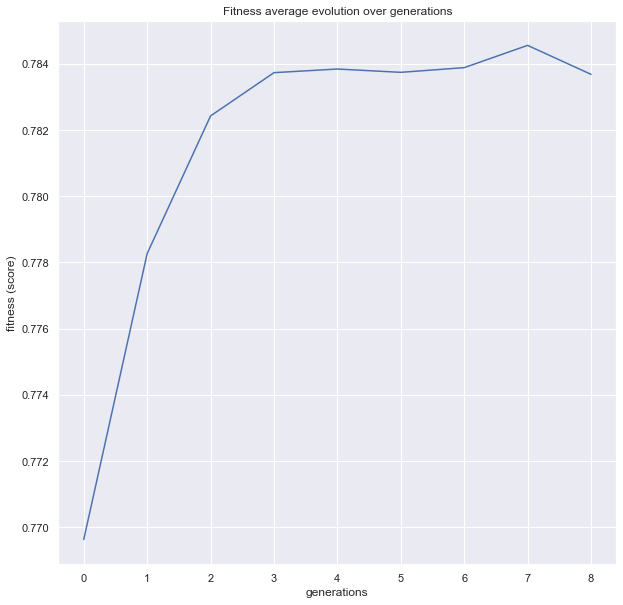

In [18]:
from sklearn_genetic.plots import plot_fitness_evolution

plot_fitness_evolution(evolved_estimator)

In [19]:
best_model = evolved_estimator.best_estimator_

## Results visualization
I coded the function below to visualize the model performance. There are 3 graphs: the ROC curve aith AUC indication (note that the 45° slope is the baseline corresponding to the randmo classifier), the confusion matrix with normalized entries, and the precision-recall curve.

C:\Users\GRI018\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


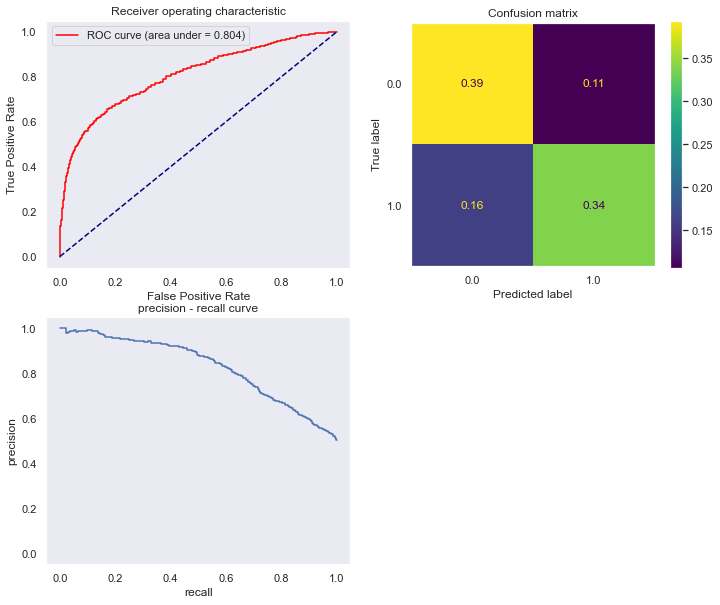

In [20]:
def plot_model_results(best_model, X_test, y_test, label_position = 1, figsize = (12, 10)):
    proba = best_model.predict_proba(X_test)
    y_score = proba[:, label_position]
    
    fpr, tpr, _ = roc_curve(y_true = y_test, y_score = y_score)

    roc_auc = roc_auc_score(y_true = y_test, y_score = y_score)
    
    precision, recall, __ = precision_recall_curve(y_true = y_test, probas_pred = y_score)
    
    from matplotlib import pyplot as plt    
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = figsize)

    axes[0,0].set_title("Receiver operating characteristic")
    axes[0,0].step(fpr, tpr, color = "red")
    axes[0,0].plot([0, 1], [0, 1], color = "navy", linestyle = "--")
    axes[0,0].set_xlabel("False Positive Rate")
    axes[0,0].set_ylabel("True Positive Rate")
    axes[0,0].grid(which = "major")
    axes[0,0].legend(labels = ["ROC curve (area under = %0.3f)" % roc_auc])
    
    plot_confusion_matrix(best_model, X_test, y_test, ax = axes[0,1], normalize = "all")
    axes[0,1].set_title("Confusion matrix")
    axes[0,1].grid(False)
    
    axes[1,0].set_title("precision - recall curve")
    axes[1,0].step(recall, precision)
    axes[1,0].set_xlabel("recall")
    axes[1,0].set_xlim(-0.05, 1.05)
    axes[1,0].set_ylabel("precision")
    axes[1,0].set_ylim(-0.05, 1.05)
    axes[1,0].grid(which = "both")
    
    fig.delaxes(axes[1,1])
    
    return fig

fig = plot_model_results(best_model, X_test[features_to_be_used], y_test)

### Assess the model with the held-out set
We can call the same plotting function defined above, to quantify the model score obtained with the held-out, heavily imbalanced dataset.

C:\Users\GRI018\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


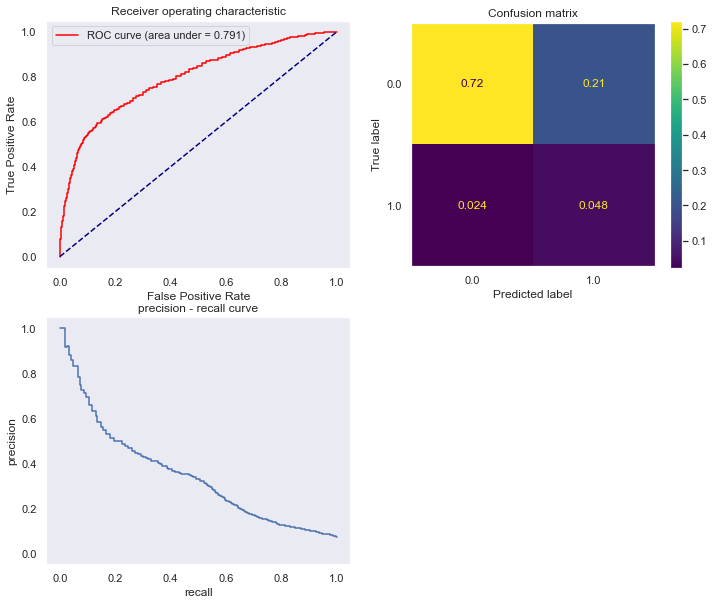

In [21]:
fig = plot_model_results(best_model, X_held_out[features_to_be_used], y_held_out)

## References
### sklearn official documentation
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

### sklearn-genetic-opt library
https://towardsdatascience.com/hyperparameters-tuning-from-grid-search-to-optimization-a09853e4e9b8#542d-6748243ca9d4
https://towardsdatascience.com/tune-your-scikit-learn-model-using-evolutionary-algorithms-30538248ac16
https://github.com/rodrigo-arenas/Sklearn-genetic-opt